# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyA/all_data/')

# Perturbing enzymes

In [3]:
Teusink_ant ='../../../models/Antimony/topologyA-noReg.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

In [4]:
pt_levels = [0, 0.1, 0.2, 0.3, 0.4,0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['knockout','0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [5]:
data_file0 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_0.csv'
data_file01 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_0.1.csv'
data_file02 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_0.2.csv'
data_file03 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_0.3.csv'
data_file04 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_0.4.csv'
data_file05 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_0.5.csv'

data_file15 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_1.5.csv'
data_file3 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_3.csv'
data_file5 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_5.csv'
data_file7 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_7.csv'
data_file100 = '../../../data/interim/generated_data/topologyA-noReg/topologyA-noReg_10.csv'


In [6]:
BMCA_obj0 = antemll.antemll(Teusink_ant, data_file0, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj01 = antemll.antemll(Teusink_ant, data_file01, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj02 = antemll.antemll(Teusink_ant, data_file02, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj03 = antemll.antemll(Teusink_ant, data_file03, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj04 = antemll.antemll(Teusink_ant, data_file04, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj05 = antemll.antemll(Teusink_ant, data_file05, '../../../models/sbml/topologyA_cobra.xml')

BMCA_obj15 = antemll.antemll(Teusink_ant, data_file15, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj3 = antemll.antemll(Teusink_ant, data_file3, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj5 = antemll.antemll(Teusink_ant, data_file5, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj7 = antemll.antemll(Teusink_ant, data_file7, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj100 = antemll.antemll(Teusink_ant, data_file100, '../../../models/sbml/topologyA_cobra.xml')


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning:

divide by zero encountered in log

No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA-noReg_cobra.ant


## Running ADVI

In [9]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.6293e+06


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,894.1


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,793.4


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,264.4


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,069.8


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,000.2


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 958.63


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,077.9


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,484.7


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,415.3


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4,877.9


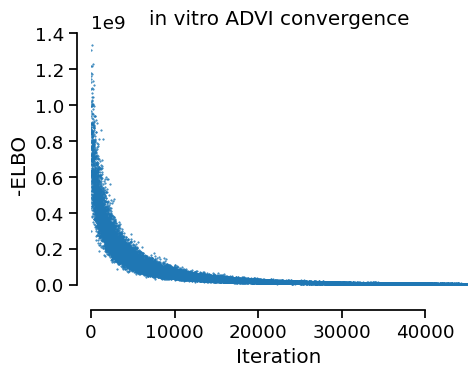

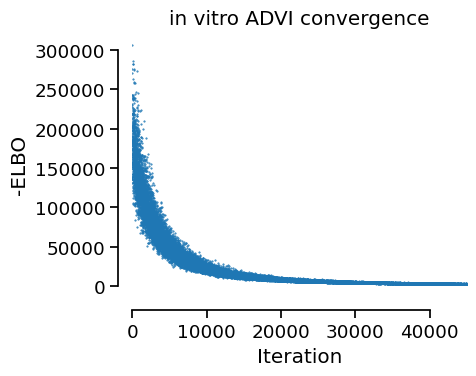

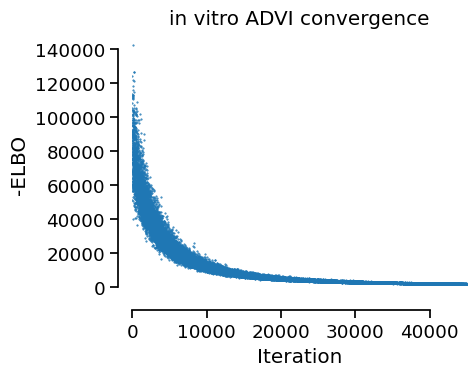

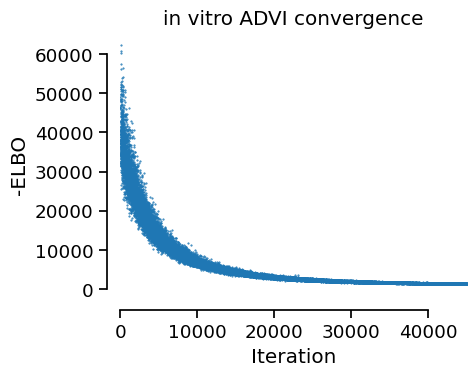

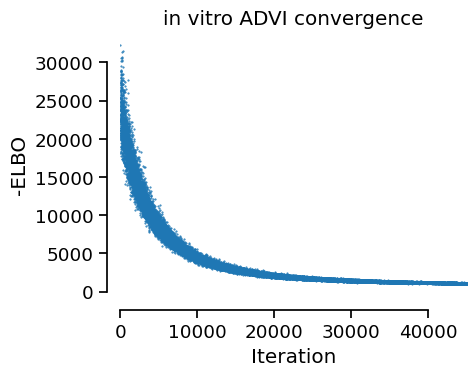

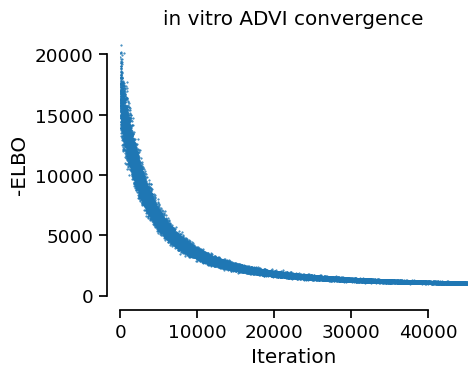

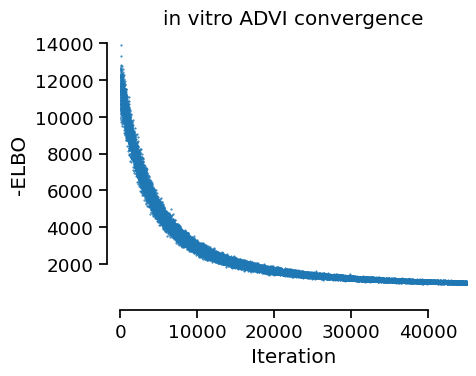

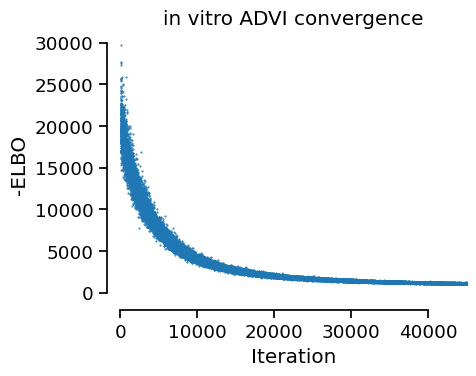

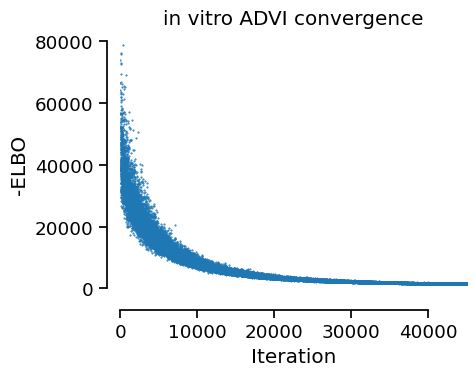

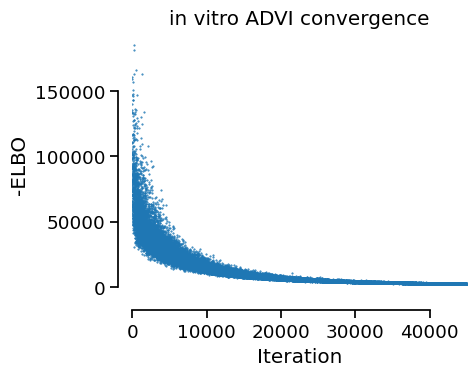

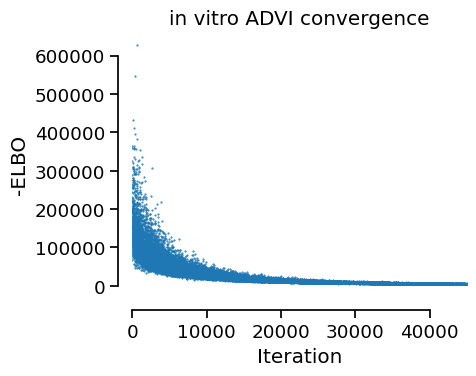

In [10]:
trace0 = run_ADVI(BMCA_obj0)
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)
trace05 = run_ADVI(BMCA_obj05)

trace15 = run_ADVI(BMCA_obj15)
trace3 = run_ADVI(BMCA_obj3)
trace5 = run_ADVI(BMCA_obj5)
trace7 = run_ADVI(BMCA_obj7)
trace100 = run_ADVI(BMCA_obj100)

### saving trace data

In [ ]:
with gzip.open("topologyA-noReg_allData_traces.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace0":trace0,
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100
                },
                f,
            )

# Analysis

In [8]:
picklefolder = '../../../data/results/tracePickles/'
# picklefolder = '../../../data/results/tracePickles-20240718/'
with gzip.open(picklefolder + 'topologyA-noReg_allData_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [9]:
trace0=traces['trace0']
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

In [10]:
Ex0_advi = util.get_az_summary(trace0)
Ex01_advi = util.get_az_summary(trace01)
Ex02_advi = util.get_az_summary(trace02)
Ex03_advi = util.get_az_summary(trace03)
Ex04_advi = util.get_az_summary(trace04)
Ex05_advi = util.get_az_summary(trace05)

Ex15_advi = util.get_az_summary(trace15)
Ex3_advi = util.get_az_summary(trace3)
Ex5_advi = util.get_az_summary(trace5)
Ex7_advi = util.get_az_summary(trace7)
Ex100_advi = util.get_az_summary(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

## Elasticity plots

In [11]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                Ex0_advi, Ex01_advi, Ex02_advi, Ex03_advi, 
                               Ex04_advi, Ex05_advi,  
                               Ex15_advi, Ex3_advi, Ex5_advi, 
                               Ex7_advi, Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels, 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA-noReg_allData_elasticities.csv')

In [12]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

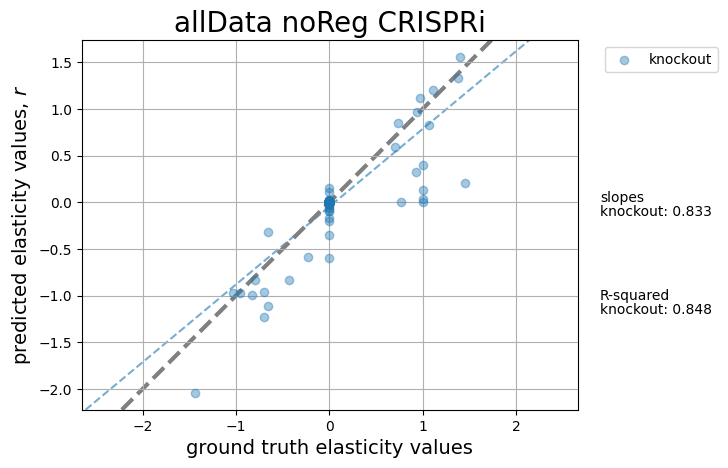

In [13]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['knockout'], alpha=0.4, label='knockout', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 2.9
line_spacing = 0.15
slope_start = 0
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate([pt_labels[0]]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate([pt_labels[0]]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(1):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

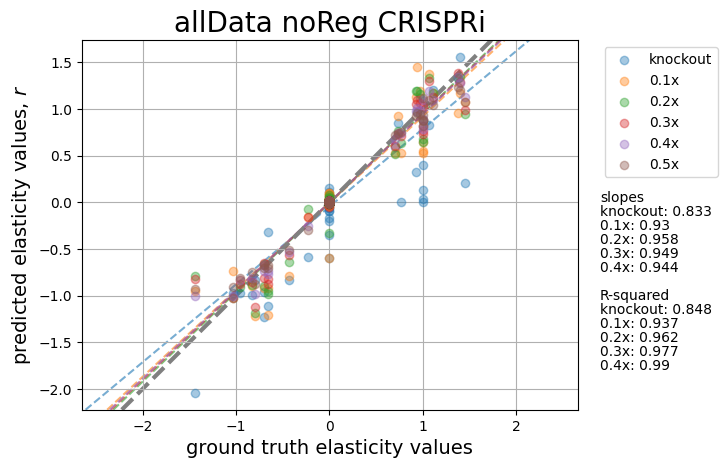

In [14]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['knockout'], alpha=0.4, label='knockout', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 2.9
line_spacing = 0.15
slope_start = 0
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

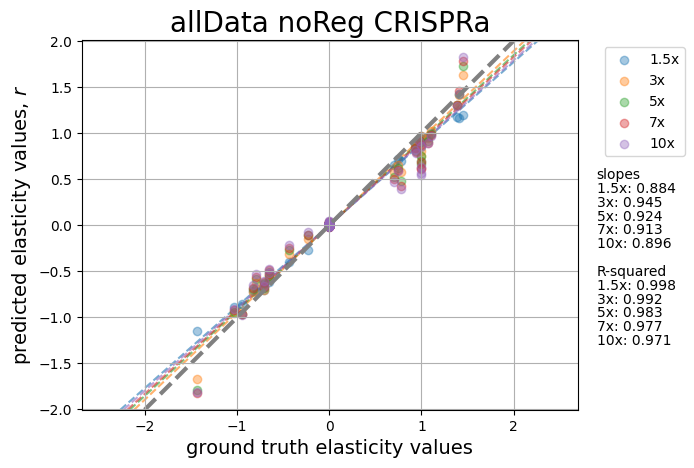

In [15]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData noReg CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 2.9
line_spacing = 0.15
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[6:11]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i+6]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[6:11]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i+6]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i+6]), slope=e_slopes[i+6], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

In [18]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()
MAE.to_csv('topologyA-noReg_allData_MAE.csv')

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

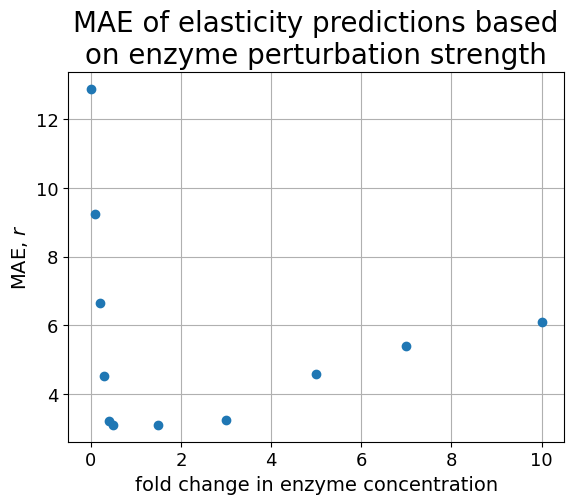

In [17]:
plt.scatter(pt_levels, MAE[1:].values, zorder=10)
plt.grid(True, which='both', axis='both', zorder=0)
# plt.xscale('log')
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

In [22]:
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()
CRISPRi_MAE = MAE[1:6]
CRISPRa_MAE = MAE[7:12]

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

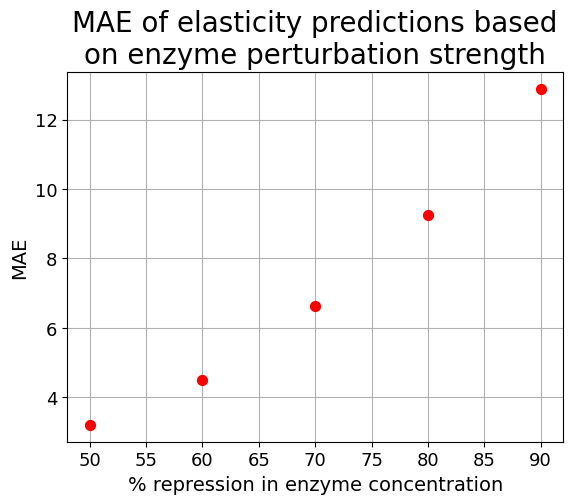

In [23]:
# CRISPRi MAE
plt.scatter(np.linspace(90,50,5), CRISPRi_MAE, zorder=10,s=50,c='r')
plt.grid(True, which='both', axis='both', zorder=0)
#plt.gca().invert_xaxis()
plt.xlabel('% repression in enzyme concentration', size=14)
plt.ylabel('MAE', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

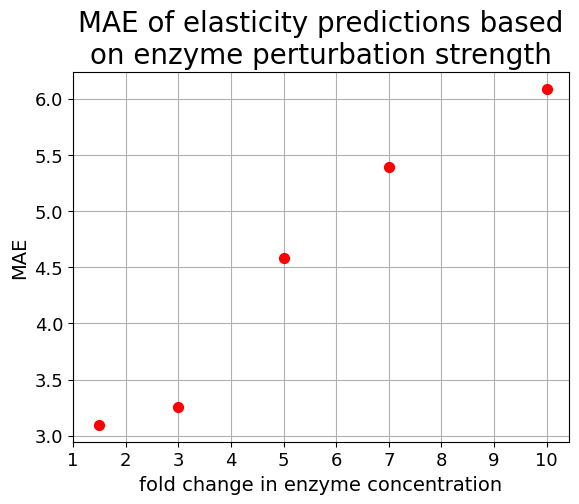

In [24]:
# CRISPRa MAE
plt.scatter(pt_levels[6:], CRISPRa_MAE, zorder=10,s=50,c='r')
plt.grid(True, which='both', axis='both', zorder=0)
plt.xticks(range(1,11))
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

## Calculating FCCs

In [25]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [26]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


### Negative predictions

In [41]:
BMCA_obj = BMCA_obj01
BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6

a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
a = np.diag(a)
a = a[np.newaxis,:].repeat(1000, axis=0)

Ex_ss = a @ Ex0_advi

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 176 is different from 16)

In [62]:
postFCC0 = estimate_CCs(BMCA_obj0, Ex0_advi.reshape((16,11)))
postFCC01 = estimate_CCs(BMCA_obj01, Ex01_advi.reshape((16,11)))
postFCC02 = estimate_CCs(BMCA_obj02, Ex02_advi.reshape((16,11)))
postFCC03 = estimate_CCs(BMCA_obj03, Ex03_advi.reshape((16,11)))
postFCC04 = estimate_CCs(BMCA_obj04, Ex04_advi.reshape((16,11)))
postFCC05 = estimate_CCs(BMCA_obj05, Ex05_advi.reshape((16,11)))

postFCC15 = estimate_CCs(BMCA_obj15, Ex15_advi.reshape((16,11)))
postFCC3 = estimate_CCs(BMCA_obj3, Ex3_advi.reshape((16,11)))
postFCC5 = estimate_CCs(BMCA_obj5, Ex5_advi.reshape((16,11)))
postFCC7 = estimate_CCs(BMCA_obj7, Ex7_advi.reshape((16,11)))
postFCC100 = estimate_CCs(BMCA_obj100, Ex100_advi.reshape((16,11)))

In [63]:
rxn_FCCs = [postFCC0, postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]


In [64]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [68]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False).round(5)
medPrdFCCs.head()

,,vKIL,vLIM,vMIK,vNOV,vOSC,vPAP,vQUE,vROM,vSIE,vTAN,vUNI,vVIC,vWHI,vALP,vYAN,vZUL
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vKIL,knockout,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
vLIM,knockout,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
vMIK,knockout,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
vNOV,knockout,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
vOSC,knockout,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0


### Graphing the averaged differences between ground truth and predicted distributions

In [66]:
plt.close("all")

## Evaluating FCC ranking

In [69]:
## ground truth FCC rankings for vYAN

gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['vYAN']

### via Spearman rank coefficients

In [70]:
def calculate_FCC_med_rankings(postFCC, reaction='vYAN'):
    postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    m1 = postFCC_med.index.values[:, None] == postFCC_med.columns.values
    postFCC = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=postFCC_med.columns, index=postFCC_med.index)
    postFCC_rankings= postFCC.rank(axis=1, ascending=False, na_option='keep')
    
    return postFCC_rankings.loc[reaction]
    

In [71]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in rxn_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


c:\Users\user\Documents\research\BMCA-pipeline\src\util.py:739: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [72]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
knockout,0.006037,9.829648e-01,NaN,NaN
0.1x,0.539286,3.802166e-02,0.077737,0.813562
0.2x,0.625000,1.272745e-02,0.173675,0.891261
0.3x,0.750000,1.280898e-03,0.275263,0.951686
0.4x,0.878571,1.631528e-05,0.618126,0.977077
0.5x,0.939286,2.094580e-07,0.741168,0.989011
1.5x,0.982143,8.157334e-11,0.890690,1.000000
3x,0.957143,2.273675e-08,0.771718,1.000000
5x,0.953571,3.792440e-08,0.760982,1.000000
7x,0.925000,7.987462e-07,0.730580,0.985107


In [73]:
spearman_df.to_csv('topologyA-noReg_allData_spr.csv')

In [ ]:
plt.bar(pt_labels, [i[0] for i in spearman_coefficients], alpha=0.5, color='r')
plt.grid()

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [ii[0] for ii in spearman_coefficients][i]), ha='center')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

### evaluating top five rankings

In [78]:
bump_df = pd.DataFrame(b_list, index=pt_levels).drop('vYAN', axis=1)# .drop(1.01)
bump_df

,vKIL,vLIM,vMIK,vNOV,vOSC,vPAP,vQUE,vROM,vSIE,vTAN,vUNI,vVIC,vWHI,vALP,vZUL
0.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0,2.0,9.0,9.0
0.1,5.0,7.0,13.0,3.0,2.0,9.0,8.0,12.0,15.0,14.0,10.0,11.0,4.0,1.0,6.0
0.2,4.0,6.0,15.0,3.0,5.0,9.0,8.0,12.0,13.0,14.0,10.0,11.0,2.0,1.0,7.0
0.3,4.0,5.0,15.0,3.0,6.0,9.0,7.0,10.0,12.0,14.0,11.0,13.0,1.0,2.0,8.0
0.4,7.0,3.0,15.0,4.0,6.0,10.0,5.0,9.0,11.0,14.0,12.0,13.0,1.0,2.0,8.0
0.5,8.0,3.0,15.0,5.0,6.0,10.0,4.0,7.0,11.0,13.0,12.0,14.0,1.0,2.0,9.0
1.5,11.0,3.0,15.0,8.0,7.0,6.0,2.0,4.0,9.0,12.0,13.0,14.0,1.0,5.0,10.0
3.0,11.0,3.0,15.0,7.0,10.0,6.0,2.0,5.0,8.0,12.0,13.0,14.0,1.0,4.0,9.0
5.0,11.0,3.0,15.0,7.0,10.0,6.0,2.0,5.0,9.0,12.0,13.0,14.0,1.0,4.0,8.0
7.0,11.0,3.0,14.0,7.0,10.0,5.0,4.0,6.0,9.0,12.0,13.0,15.0,1.0,2.0,8.0


In [95]:
rasta = pd.DataFrame(bump_df.iloc[0].sort_index())
rasta['gt'] = a.sort_index()
rasta.T

,vALP,vKIL,vLIM,vMIK,vNOV,vOSC,vPAP,vQUE,vROM,vSIE,vTAN,vUNI,vVIC,vWHI,vZUL
0.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0,2.0,9.0
gt,4.0,11.0,3.0,15.0,7.0,6.0,8.0,2.0,5.0,9.0,13.0,12.0,14.0,1.0,10.0


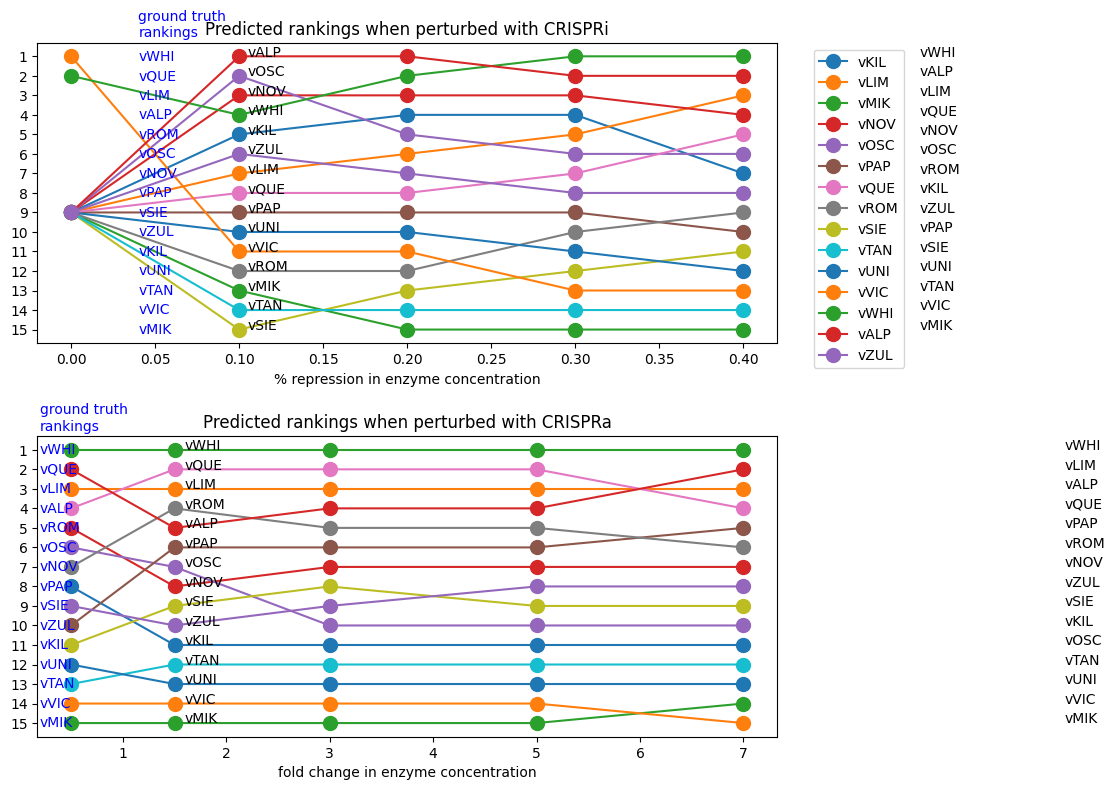

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
# ax.set_prop_cycle('color', list(cm))
gt_rank = a.drop('vYAN', axis=0).values.reshape((-1,15))

ax[0].plot(bump_df.index[0:5], bump_df.values[0:5], marker='o', markersize=10, label=list(bump_df.columns))
ax[1].plot(bump_df.index[5:10], bump_df.values[5:10], marker='o', markersize=10, label=list(bump_df.columns))

ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")

for i,rxn in enumerate(list(a.sort_values().index)[:-1]):
    ax[0].text(0.04, i+1.2, rxn, color='b')
    ax[1].text(0.2, i+1.2, rxn, color='b')

ax[0].text(0.04, 0, 'ground truth\nrankings', color='b')
ax[1].text(0.2, 0, 'ground truth\nrankings', color='b')

for i,rxn in enumerate(list(bump_df.loc[0.1].sort_values().index)):
    ax[0].text(0.105, i+1, rxn)

for i,rxn in enumerate(list(bump_df.loc[0.5].sort_values().index)):
    ax[0].text(0.505, i+1, rxn)

for i,rxn in enumerate(list(bump_df.loc[1.5].sort_values().index)):
    ax[1].text(1.6, i+1, rxn)

for i,rxn in enumerate(list(bump_df.loc[10].sort_values().index)):
    ax[1].text(10.11, i+1, rxn)

ax[0].set_yticks(range(1,16))
ax[1].set_yticks(range(1,16))

ax[0].invert_yaxis()
ax[1].invert_yaxis()

ax[0].set_title('Predicted rankings when perturbed with CRISPRi')
ax[0].set_xlabel('% repression in enzyme concentration')
ax[1].set_title('Predicted rankings when perturbed with CRISPRa')
ax[1].set_xlabel('fold change in enzyme concentration')

plt.tight_layout()
plt.show()

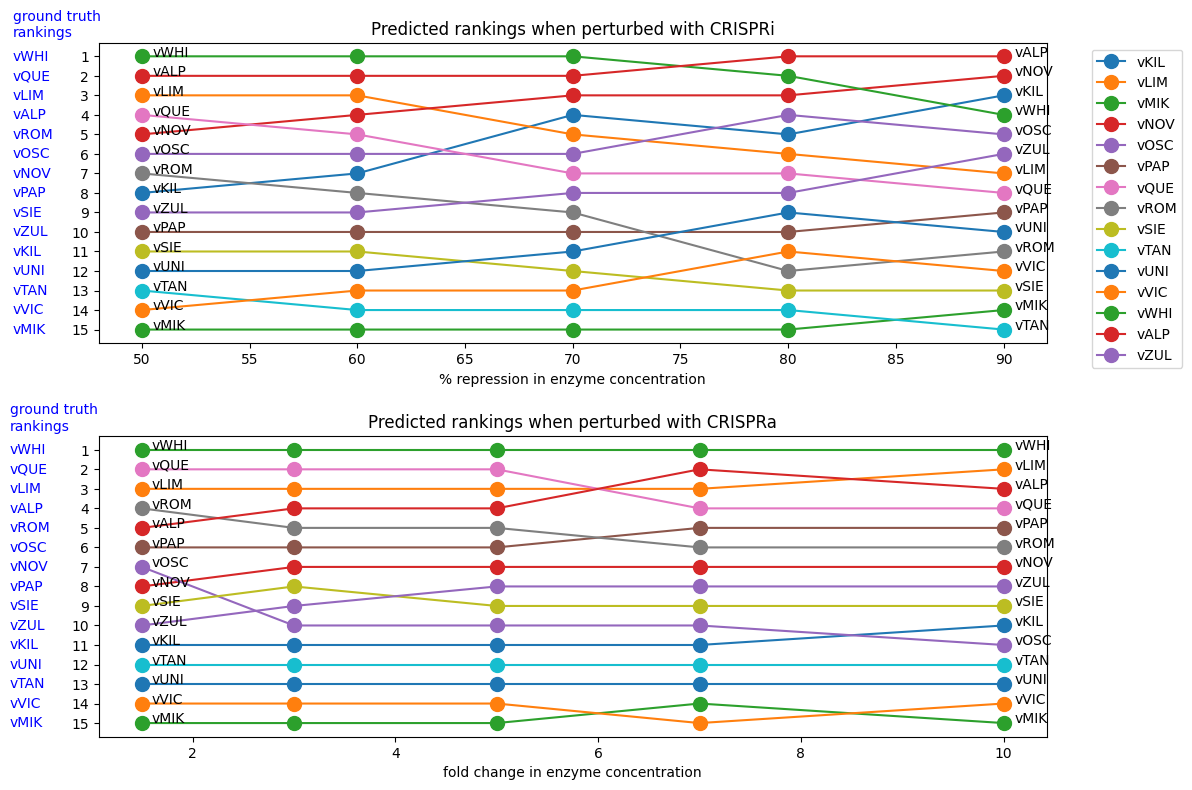

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
# ax.set_prop_cycle('color', list(cm))
gt_rank = a.drop('vYAN', axis=0).values.reshape((-1,15))

ax[0].plot(np.linspace(90,50,5), bump_df.values[0:5], marker='o', markersize=10, label=list(bump_df.columns))
ax[1].plot(bump_df.index[5:10], bump_df.values[5:10], marker='o', markersize=10, label=list(bump_df.columns))

ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")

for i,rxn in enumerate(list(a.sort_values().index)[:-1]):
    ax[0].text(44, i+1.2, rxn, color='b')
    ax[1].text(0.2, i+1.2, rxn, color='b')

ax[0].text(44, 0, 'ground truth\nrankings', color='b')
ax[1].text(0.2, 0, 'ground truth\nrankings', color='b')

for i,rxn in enumerate(list(bump_df.loc[0.1].sort_values().index)):
    ax[0].text(90.5, i+1, rxn)

for i,rxn in enumerate(list(bump_df.loc[0.5].sort_values().index)):
    ax[0].text(50.5, i+1, rxn)

for i,rxn in enumerate(list(bump_df.loc[1.5].sort_values().index)):
    ax[1].text(1.6, i+1, rxn)

for i,rxn in enumerate(list(bump_df.loc[10].sort_values().index)):
    ax[1].text(10.11, i+1, rxn)

ax[0].set_yticks(range(1,16))
ax[1].set_yticks(range(1,16))

ax[0].invert_yaxis()
ax[1].invert_yaxis()

ax[0].set_title('Predicted rankings when perturbed with CRISPRi')
ax[0].set_xlabel('% repression in enzyme concentration')
ax[1].set_title('Predicted rankings when perturbed with CRISPRa')
ax[1].set_xlabel('fold change in enzyme concentration')

plt.tight_layout()
plt.show()

In [87]:
ranked_b_list = [b.sort_values().reset_index().set_index('vYAN') for b in b_list[1:]]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('vYAN')
q.columns = pt_labels[1:] + ['gt']
q = q[['gt'] + pt_labels[1:]]
q

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.5x,3x,5x,7x,10x
vYAN,,,,,,,,,,,
1.0,vWHI,vALP,vALP,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI
2.0,vQUE,vOSC,vWHI,vALP,vALP,vALP,vQUE,vQUE,vQUE,vALP,vLIM
3.0,vLIM,vNOV,vNOV,vNOV,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM,vALP
4.0,vALP,vWHI,vKIL,vKIL,vNOV,vQUE,vROM,vALP,vALP,vQUE,vQUE
5.0,vROM,vKIL,vOSC,vLIM,vQUE,vNOV,vALP,vROM,vROM,vPAP,vPAP
6.0,vOSC,vZUL,vLIM,vOSC,vOSC,vOSC,vPAP,vPAP,vPAP,vROM,vROM
7.0,vNOV,vLIM,vZUL,vQUE,vKIL,vROM,vOSC,vNOV,vNOV,vNOV,vNOV
8.0,vPAP,vQUE,vQUE,vZUL,vZUL,vKIL,vNOV,vSIE,vZUL,vZUL,vZUL
9.0,vSIE,vPAP,vPAP,vPAP,vROM,vZUL,vSIE,vZUL,vSIE,vSIE,vSIE


In [29]:
q.to_csv('topologyA-noReg_allData_rankings.csv')